In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd

plt.style.use('ggplot')
pd.set_option('display.max_columns', 30)

In [2]:
# import trip data
df = pd.read_csv('data/citibike_ZIP.csv')

In [3]:
# explore supply and demand
# find number of hourly trip starts and ends by zipcode

starts_hrly = df.groupby(['hour','zip_start'], as_index = False)[['bikeid']].count()
starts_hrly.columns = ['hour','zip_start','start_count']
starts_hrly

,hour,zip_start,start_count
0,0,83,274
1,0,10001,554
2,0,10002,705
3,0,10003,811
4,0,10004,68
...,...,...,...
1717,23,11237,289
1718,23,11238,525
1719,23,11249,800
1720,23,11251,29


In [4]:
ends_hrly = df.groupby(['hour','zip_end'], as_index = False)[['bikeid']].count()
ends_hrly.columns = ['hour','zip_end','end_count']
ends_hrly

,hour,zip_end,end_count
0,0,83.0,213
1,0,10001.0,562
2,0,10002.0,762
3,0,10003.0,785
4,0,10004.0,82
...,...,...,...
1717,23,11237.0,321
1718,23,11238.0,531
1719,23,11249.0,482
1720,23,11251.0,37


In [5]:
supply_hrly = starts_hrly.merge(ends_hrly,
                               left_on = ['hour','zip_start'],
                               right_on = ['hour','zip_end'],
                               how = 'outer')
supply_hrly.head(10)

,hour,zip_start,start_count,zip_end,end_count
0,0,83.0,274.0,83.0,213.0
1,0,10001.0,554.0,10001.0,562.0
2,0,10002.0,705.0,10002.0,762.0
3,0,10003.0,811.0,10003.0,785.0
4,0,10004.0,68.0,10004.0,82.0
5,0,10005.0,118.0,10005.0,124.0
6,0,10007.0,201.0,10007.0,175.0
7,0,10009.0,623.0,10009.0,675.0
8,0,10010.0,156.0,10010.0,191.0
9,0,10011.0,626.0,10011.0,549.0


In [6]:
supply_hrly['end_count'].fillna(0, inplace=True)
supply_hrly['start_count'].fillna(0, inplace=True)

In [7]:
# define hourly surplus as the difference between hourly end count and start count in a zipcode
# find daily average by dividing by 30

supply_hrly['hrly_surplus'] = (supply_hrly['end_count'] - supply_hrly['start_count'])/30
supply_hrly.head()

,hour,zip_start,start_count,zip_end,end_count,hrly_surplus
0,0,83.0,274.0,83.0,213.0,-2.033333
1,0,10001.0,554.0,10001.0,562.0,0.266667
2,0,10002.0,705.0,10002.0,762.0,1.900000
3,0,10003.0,811.0,10003.0,785.0,-0.866667
4,0,10004.0,68.0,10004.0,82.0,0.466667


In [39]:
# group surplus and deficit for PM hours
supply_PM = supply_hrly[(supply_hrly['hour'] > 15) & (supply_hrly['hour'] < 22)] # 4-9 pm
count_PM = supply_PM.groupby('zip_start', as_index = False)[['start_count','end_count']].sum()
count_PM.columns = ['zip','start_PM','end_PM']
count_PM.head()

,zip,start_PM,end_PM
0,83.0,35312.0,30912.0
1,10001.0,27326.0,25029.0
2,10002.0,32600.0,35506.0
3,10003.0,40910.0,40819.0
4,10004.0,5346.0,4749.0


In [40]:
# calculate daily average
count_PM['surplus_PM'] = count_PM['end_PM'] - count_PM['start_PM']
count_PM['surplus_PM_daily'] = count_PM['surplus_PM']/30
count_PM.head()

,zip,start_PM,end_PM,surplus_PM,surplus_PM_daily
0,83.0,35312.0,30912.0,-4400.0,-146.666667
1,10001.0,27326.0,25029.0,-2297.0,-76.566667
2,10002.0,32600.0,35506.0,2906.0,96.866667
3,10003.0,40910.0,40819.0,-91.0,-3.033333
4,10004.0,5346.0,4749.0,-597.0,-19.900000


In [41]:
# aggregated for PM hours:
# top 1 deficit is Central Park (83)
count_PM.sort_values(by = ['surplus_PM_daily']).head(1)

,zip,start_PM,end_PM,surplus_PM,surplus_PM_daily
0,83.0,35312.0,30912.0,-4400.0,-146.666667


In [42]:
# aggregated for PM hours:
# top 1 surplus is East village (10009)
count_PM.sort_values(by = ['surplus_PM_daily'], ascending = False).head(1)

,zip,start_PM,end_PM,surplus_PM,surplus_PM_daily
7,10009.0,26545.0,32376.0,5831.0,194.366667


In [43]:
# import zipcode shapefile
zip_shp = gpd.read_file('nyc_zip/ZIP_CODE_040114.shp')
zip_shp['ZIPCODE'] = zip_shp['ZIPCODE'].astype(int)

In [44]:
# merge with AM/PM surplus and deficit
zip_shp = zip_shp.merge(
    count_PM, 
    left_on='ZIPCODE',
    right_on='zip',
    how='left')
zip_shp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,zip,start_PM,end_PM,surplus_PM,surplus_PM_daily
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ...",NaN,NaN,NaN,NaN,NaN
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ...",NaN,NaN,NaN,NaN,NaN
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ...",NaN,NaN,NaN,NaN,NaN
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18...",11225.0,4403.0,4586.0,183.0,6.1
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17...",NaN,NaN,NaN,NaN,NaN


In [22]:
zip_shp['surplus_AM'].fillna(0, inplace=True)
zip_shp['surplus_PM'].fillna(0, inplace=True)
zip_shp['surplus_AM_daily'].fillna(0, inplace=True)
zip_shp['surplus_PM_daily'].fillna(0, inplace=True)

In [45]:
# group evening trips by start and end location

start_PM = df.groupby(['zip_start','zip_end'], as_index = False)[['bikeid']].count().\
    rename(columns = {'bikeid': 'count'})
start_PM['daily_avg'] = start_PM['count']/28
start_PM.sort_values(by = 'daily_avg', ascending = False).head(10)

,zip_start,zip_end,count,daily_avg
3341,11201,11201.0,24827,886.678571
144,10002,10002.0,23012,821.857143
0,83,83.0,19924,711.571429
623,10011,10011.0,16892,603.285714
215,10003,10003.0,16352,584.000000
480,10009,10009.0,15965,570.178571
2972,11101,11101.0,15586,556.642857
1742,10029,10029.0,12608,450.285714
3640,11215,11215.0,11757,419.892857
3579,11211,11211.0,11344,405.142857


In [46]:
end_PM = df.groupby(['zip_end','zip_start'], as_index = False)[['bikeid']].count().\
    rename(columns = {'bikeid': 'count'})
end_PM['daily_avg'] = end_PM['count']/28
end_PM.sort_values(by = 'daily_avg', ascending = False).head(10)

,zip_end,zip_start,count,daily_avg
3337,11201.0,11201,24827,886.678571
142,10002.0,10002,23012,821.857143
0,83.0,83,19924,711.571429
631,10011.0,10011,16892,603.285714
212,10003.0,10003,16352,584.000000
489,10009.0,10009,15965,570.178571
2966,11101.0,11101,15586,556.642857
1735,10029.0,10029,12608,450.285714
3641,11215.0,11215,11757,419.892857
3575,11211.0,11211,11344,405.142857


In [47]:
# evening trips that start in Central Park
PM_centpark = start_PM[start_PM['zip_start'] == 83]
PM_centpark.sort_values(by = 'count', ascending = False).head(10)

,zip_start,zip_end,count,daily_avg
0,83,83.0,19924,711.571429
16,83,10019.0,5446,194.500000
19,83,10023.0,4259,152.107143
20,83,10024.0,3395,121.250000
21,83,10025.0,3275,116.964286
22,83,10026.0,2820,100.714286
25,83,10029.0,2808,100.285714
17,83,10021.0,2304,82.285714
23,83,10027.0,2045,73.035714
24,83,10028.0,1996,71.285714


In [28]:
# evening trips that end in East Village
PM_eastvil = end_PM[end_PM['zip_end'] == 10009]
PM_eastvil.sort_values(by = 'count', ascending = False).head(10)

,zip_end,zip_start,count,daily_avg
489,10009.0,10009,15965,570.178571
485,10009.0,10003,9328,333.142857
484,10009.0,10002,7623,272.250000
495,10009.0,10016,4118,147.071429
491,10009.0,10011,3124,111.571429
494,10009.0,10014,2782,99.357143
492,10009.0,10012,2323,82.964286
490,10009.0,10010,2021,72.178571
493,10009.0,10013,1849,66.035714
483,10009.0,10001,1517,54.178571


In [48]:
# merge trips from Central Park with shapefile
zip_fromcentpark = zip_shp.merge(
    PM_centpark, 
    left_on='ZIPCODE',
    right_on='zip_end',
    how='left')
zip_fromcentpark.sort_values(by = 'count', ascending = False).head(6)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,zip,start_PM,end_PM,surplus_PM,surplus_PM_daily,zip_start,zip_end,count,daily_avg
54,83,0,Central Park,25.0,3.830099e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((998309.725 229616.681, 998282.853 22...",83.0,35312.0,30912.0,-4400.0,-146.666667,83.0,83.0,19924.0,711.571429
187,10019,0,New York,41966.0,1.882838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((986161.713 220802.608, 986480.821 22...",10019.0,28382.0,27430.0,-952.0,-31.733333,83.0,10019.0,5446.0,194.500000
60,10023,0,New York,62800.0,1.521271e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((986170.321 221389.159, 986464.435 22...",10023.0,20290.0,19746.0,-544.0,-18.133333,83.0,10023.0,4259.0,152.107143
46,10024,0,New York,58521.0,2.287734e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((994210.038 234868.661, 994182.279 23...",10024.0,15462.0,15913.0,451.0,15.033333,83.0,10024.0,3395.0,121.250000
51,10025,0,New York,96054.0,1.963104e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((995501.655 232971.115, 995396.152 23...",10025.0,12627.0,13705.0,1078.0,35.933333,83.0,10025.0,3275.0,116.964286
48,10026,0,New York,34313.0,1.109268e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((999588.262 231919.431, 999462.779 23...",10026.0,8869.0,9970.0,1101.0,36.700000,83.0,10026.0,2820.0,100.714286


In [49]:
zip_fromcentpark['daily_avg'].fillna(0, inplace = True)

In [50]:
# merge trips to East Village with shapefile
zip_toeastvil = zip_shp.merge(
    PM_eastvil, 
    left_on='ZIPCODE',
    right_on='zip_start',
    how='left')
zip_toeastvil.sort_values(by = 'count', ascending = False).head(6)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,zip,start_PM,end_PM,surplus_PM,surplus_PM_daily,zip_end,zip_start,count,daily_avg
94,10009,0,New York,61455.0,1.590352e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991606.403 205494.146, 991619.927 20...",10009.0,26545.0,32376.0,5831.0,194.366667,10009.0,10009.0,15965.0,570.178571
90,10003,0,New York,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",10003.0,40910.0,40819.0,-91.0,-3.033333,10009.0,10003.0,9328.0,333.142857
92,10002,0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",10002.0,32600.0,35506.0,2906.0,96.866667,10009.0,10002.0,7623.0,272.250000
84,10016,0,New York,54606.0,1.504240e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989286.343 213322.780, 989730.129 21...",10016.0,28287.0,25424.0,-2863.0,-95.433333,10009.0,10016.0,4118.0,147.071429
83,10011,0,New York,50594.0,1.811842e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((986378.434 210178.599, 986279.129 20...",10011.0,35582.0,36805.0,1223.0,40.766667,10009.0,10011.0,3124.0,111.571429
89,10014,0,New York,31328.0,1.415105e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((983985.485 205856.726, 983867.870 20...",10014.0,32885.0,33350.0,465.0,15.500000,10009.0,10014.0,2782.0,99.357143


In [51]:
zip_toeastvil['daily_avg'].fillna(0, inplace = True)

[]

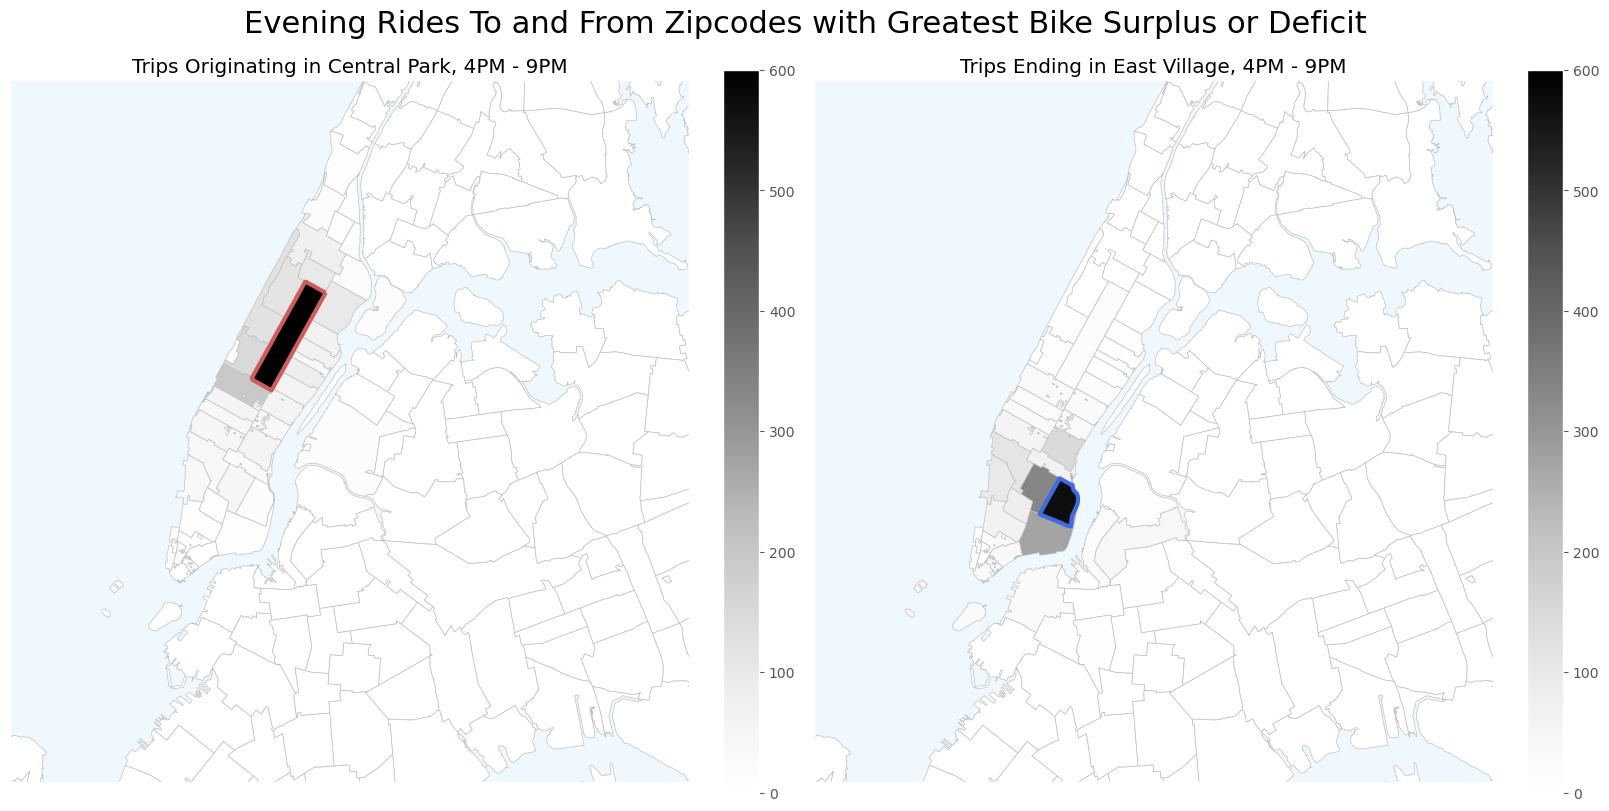

In [52]:
# choropleths depicting most frequent origins and destinations
# for zipcodes with greatest evening surplus or deficit

from matplotlib.colors import Normalize
norm = Normalize(vmin=0, vmax=600)

fig, (ax1, ax2) = plt.subplots(1,2, 
                        figsize=(16, 8),
                        sharex=False,
                        sharey=False,
                        constrained_layout=True)
fig.suptitle('Evening Rides To and From Zipcodes with Greatest Bike Surplus or Deficit', fontsize=22)

zip_fromcentpark.plot(ax=ax1, column= 'daily_avg', norm=norm, cmap='Greys', edgecolor = 'silver', legend=True)
zip_fromcentpark.loc[zip_shp['ZIPCODE'] == 83].plot(
    ax=ax1, column= 'daily_avg', norm=norm, cmap='Greys', edgecolor='indianred', linewidth = 3)

ax1.title.set_text('Trips Originating in Central Park, 4PM - 9PM')
ax1.set_xlim(960000, 1042546)
ax1.set_ylim(170056, 255352)
ax1.set_facecolor("aliceblue")
ax1.grid(False)
ax1.set_xticks([])
ax1.set_yticks([])

zip_toeastvil.plot(ax=ax2, column='daily_avg', norm=norm, cmap='Greys', edgecolor = 'silver', legend=True)
zip_toeastvil.loc[zip_shp['ZIPCODE'] == 10009].plot(
    ax=ax2, column= 'daily_avg', norm=norm, cmap='Greys', edgecolor='royalblue', linewidth = 3)

ax2.title.set_text('Trips Ending in East Village, 4PM - 9PM')
ax2.set_xlim(960000, 1042546)
ax2.set_ylim(170056, 255352)
ax2.set_facecolor("aliceblue")
ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])